In [1]:
from tqdm import tqdm
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
import torchvision.models as models
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator
from numpy.random import RandomState
import numpy as np
import torch
import torch.optim as optim
from torch.utils.data import Subset
import re
from torchvision import datasets, transforms

In [2]:
def train(model, device, train_loader, optimizer, epoch, display=True):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.binary_cross_entropy_with_logits(output, target.float())
        loss.backward()
        optimizer.step()
    if display:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))
    return loss.item()

def test(model, device, test_loader, name="\nVal"):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.binary_cross_entropy_with_logits(output, target.float(), size_average=False).item() # sum up batch loss
            pred = output >= 0.5 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('{} set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        name, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset)

In [3]:
def resNet18():
    resNet18 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
    resNet18.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    resNet18.fc = nn.Linear(in_features=512, out_features=1, bias=True)
    return resNet18

In [4]:
%%time
from torchvision.transforms.autoaugment import RandAugment

torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
random.seed(0)
np.random.seed(0)

# preprocessing
data_flag = 'pneumoniamnist'

download = True

info = INFO[data_flag]
n_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])

trn_transform = transforms.Compose([transforms.RandAugment(),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[.5], std=[.5])])

val_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(mean=[.5], std=[.5])])

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# load the data
train_dataset = DataClass(split='train', transform=trn_transform, download=download)
val_dataset = DataClass(split='train', transform=val_transform, download=download)

accs_val = []

for seed in  range(0, 50):
  prng = RandomState(seed)
  random_permute = prng.permutation(np.arange(0, 1000))
  train_top = 10//n_classes
  val_top = 1000//n_classes
  indx_train = np.concatenate([np.where(train_dataset.labels == label)[0][random_permute[0:train_top]] for label in range(0, n_classes)])
  indx_val = np.concatenate([np.where(train_dataset.labels == label)[0][random_permute[train_top:train_top + val_top]] for label in range(0, n_classes)])

  train_data = Subset(train_dataset, indx_train)
  val_data = Subset(val_dataset, indx_val)

  print('Num Samples For Training %d Num Samples For Val %d'%(train_data.indices.shape[0],val_data.indices.shape[0]))

  train_loader = torch.utils.data.DataLoader(train_data,
                                             batch_size=32, 
                                             shuffle=True)

  val_loader = torch.utils.data.DataLoader(val_data,
                                             batch_size=128, 
                                             shuffle=False)

  model = resNet18()
  model.to(device)

  optimizer = torch.optim.AdamW(model.parameters(),lr=1e-3)

  for epoch in range(250):
    train(model, device, train_loader, optimizer, epoch, display=epoch%5==0)
  accs_val.append(test(model, device, val_loader))

accs_val = np.array(accs_val)

print('Val acc over 5 instances on dataset: %s %.2f +- %.2f (var: %.2f)'%(data_flag, accs_val.mean(), accs_val.std(), accs_val.var()))
     

Using downloaded and verified file: C:\Users\kesha\.medmnist\pneumoniamnist.npz
Using downloaded and verified file: C:\Users\kesha\.medmnist\pneumoniamnist.npz
Num Samples For Training 10 Num Samples For Val 1000


Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\kesha\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kesha\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Train Epoch: 0 [0/10 (0%)]	Loss: 0.781428
Train Epoch: 5 [0/10 (0%)]	Loss: 1.003671
Train Epoch: 10 [0/10 (0%)]	Loss: 0.098530
Train Epoch: 15 [0/10 (0%)]	Loss: 0.644196
Train Epoch: 20 [0/10 (0%)]	Loss: 0.020565
Train Epoch: 25 [0/10 (0%)]	Loss: 0.267209
Train Epoch: 30 [0/10 (0%)]	Loss: 0.295453
Train Epoch: 35 [0/10 (0%)]	Loss: 0.084762
Train Epoch: 40 [0/10 (0%)]	Loss: 0.325636
Train Epoch: 45 [0/10 (0%)]	Loss: 0.080568
Train Epoch: 50 [0/10 (0%)]	Loss: 0.012925
Train Epoch: 55 [0/10 (0%)]	Loss: 0.011227
Train Epoch: 60 [0/10 (0%)]	Loss: 0.033083
Train Epoch: 65 [0/10 (0%)]	Loss: 0.128166
Train Epoch: 70 [0/10 (0%)]	Loss: 0.001763
Train Epoch: 75 [0/10 (0%)]	Loss: 0.022435
Train Epoch: 80 [0/10 (0%)]	Loss: 0.001905
Train Epoch: 85 [0/10 (0%)]	Loss: 0.000678
Train Epoch: 90 [0/10 (0%)]	Loss: 0.035764
Train Epoch: 95 [0/10 (0%)]	Loss: 0.005482
Train Epoch: 100 [0/10 (0%)]	Loss: 0.000644
Train Epoch: 105 [0/10 (0%)]	Loss: 0.001245
Train Epoch: 110 [0/10 (0%)]	Loss: 0.011887
Train Epoc

c:\Users\kesha\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Val set: Average loss: 0.3901, Accuracy: 892/1000 (89.20%)

Num Samples For Training 10 Num Samples For Val 1000


Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.767113
Train Epoch: 5 [0/10 (0%)]	Loss: 0.227426
Train Epoch: 10 [0/10 (0%)]	Loss: 1.443850
Train Epoch: 15 [0/10 (0%)]	Loss: 0.473709
Train Epoch: 20 [0/10 (0%)]	Loss: 0.828281
Train Epoch: 25 [0/10 (0%)]	Loss: 0.096772
Train Epoch: 30 [0/10 (0%)]	Loss: 0.018785
Train Epoch: 35 [0/10 (0%)]	Loss: 0.135262
Train Epoch: 40 [0/10 (0%)]	Loss: 0.025749
Train Epoch: 45 [0/10 (0%)]	Loss: 0.056366
Train Epoch: 50 [0/10 (0%)]	Loss: 0.008588
Train Epoch: 55 [0/10 (0%)]	Loss: 0.077147
Train Epoch: 60 [0/10 (0%)]	Loss: 0.034508
Train Epoch: 65 [0/10 (0%)]	Loss: 0.035536
Train Epoch: 70 [0/10 (0%)]	Loss: 0.020772
Train Epoch: 75 [0/10 (0%)]	Loss: 0.250135
Train Epoch: 80 [0/10 (0%)]	Loss: 0.077962
Train Epoch: 85 [0/10 (0%)]	Loss: 0.050719
Train Epoch: 90 [0/10 (0%)]	Loss: 0.181295
Train Epoch: 95 [0/10 (0%)]	Loss: 0.023763
Train Epoch: 100 [0/10 (0%)]	Loss: 0.370447
Train Epoch: 105 [0/10 (0%)]	Loss: 0.074006
Train Epoch: 110 [0/10 (0%)]	Loss: 0.031906
Train Epoc

Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.768921
Train Epoch: 5 [0/10 (0%)]	Loss: 0.060248
Train Epoch: 10 [0/10 (0%)]	Loss: 1.348155
Train Epoch: 15 [0/10 (0%)]	Loss: 0.005688
Train Epoch: 20 [0/10 (0%)]	Loss: 0.022410
Train Epoch: 25 [0/10 (0%)]	Loss: 0.028682
Train Epoch: 30 [0/10 (0%)]	Loss: 0.059426
Train Epoch: 35 [0/10 (0%)]	Loss: 0.159300
Train Epoch: 40 [0/10 (0%)]	Loss: 0.114279
Train Epoch: 45 [0/10 (0%)]	Loss: 0.048076
Train Epoch: 50 [0/10 (0%)]	Loss: 0.016097
Train Epoch: 55 [0/10 (0%)]	Loss: 0.086661
Train Epoch: 60 [0/10 (0%)]	Loss: 0.029170
Train Epoch: 65 [0/10 (0%)]	Loss: 0.002130
Train Epoch: 70 [0/10 (0%)]	Loss: 0.007134
Train Epoch: 75 [0/10 (0%)]	Loss: 0.009240
Train Epoch: 80 [0/10 (0%)]	Loss: 0.006794
Train Epoch: 85 [0/10 (0%)]	Loss: 0.337692
Train Epoch: 90 [0/10 (0%)]	Loss: 0.392474
Train Epoch: 95 [0/10 (0%)]	Loss: 0.503969
Train Epoch: 100 [0/10 (0%)]	Loss: 0.076565
Train Epoch: 105 [0/10 (0%)]	Loss: 0.082216
Train Epoch: 110 [0/10 (0%)]	Loss: 0.016308
Train Epoc

Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.872405
Train Epoch: 5 [0/10 (0%)]	Loss: 0.957213
Train Epoch: 10 [0/10 (0%)]	Loss: 0.611163
Train Epoch: 15 [0/10 (0%)]	Loss: 0.510256
Train Epoch: 20 [0/10 (0%)]	Loss: 0.823783
Train Epoch: 25 [0/10 (0%)]	Loss: 0.111430
Train Epoch: 30 [0/10 (0%)]	Loss: 0.044561
Train Epoch: 35 [0/10 (0%)]	Loss: 0.017028
Train Epoch: 40 [0/10 (0%)]	Loss: 0.078862
Train Epoch: 45 [0/10 (0%)]	Loss: 0.014247
Train Epoch: 50 [0/10 (0%)]	Loss: 0.030882
Train Epoch: 55 [0/10 (0%)]	Loss: 0.604875
Train Epoch: 60 [0/10 (0%)]	Loss: 0.012040
Train Epoch: 65 [0/10 (0%)]	Loss: 0.033905
Train Epoch: 70 [0/10 (0%)]	Loss: 0.093654
Train Epoch: 75 [0/10 (0%)]	Loss: 0.030482
Train Epoch: 80 [0/10 (0%)]	Loss: 0.224084
Train Epoch: 85 [0/10 (0%)]	Loss: 0.023567
Train Epoch: 90 [0/10 (0%)]	Loss: 0.099970
Train Epoch: 95 [0/10 (0%)]	Loss: 0.194917
Train Epoch: 100 [0/10 (0%)]	Loss: 0.011062
Train Epoch: 105 [0/10 (0%)]	Loss: 0.121333
Train Epoch: 110 [0/10 (0%)]	Loss: 0.031192
Train Epoc

Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.602278
Train Epoch: 5 [0/10 (0%)]	Loss: 1.106701
Train Epoch: 10 [0/10 (0%)]	Loss: 0.156183
Train Epoch: 15 [0/10 (0%)]	Loss: 0.263197
Train Epoch: 20 [0/10 (0%)]	Loss: 0.072756
Train Epoch: 25 [0/10 (0%)]	Loss: 0.073182
Train Epoch: 30 [0/10 (0%)]	Loss: 0.051043
Train Epoch: 35 [0/10 (0%)]	Loss: 0.012578
Train Epoch: 40 [0/10 (0%)]	Loss: 0.020857
Train Epoch: 45 [0/10 (0%)]	Loss: 0.021313
Train Epoch: 50 [0/10 (0%)]	Loss: 0.287496
Train Epoch: 55 [0/10 (0%)]	Loss: 0.025507
Train Epoch: 60 [0/10 (0%)]	Loss: 0.007177
Train Epoch: 65 [0/10 (0%)]	Loss: 0.006038
Train Epoch: 70 [0/10 (0%)]	Loss: 0.002822
Train Epoch: 75 [0/10 (0%)]	Loss: 0.001578
Train Epoch: 80 [0/10 (0%)]	Loss: 0.002621
Train Epoch: 85 [0/10 (0%)]	Loss: 0.001378
Train Epoch: 90 [0/10 (0%)]	Loss: 0.000994
Train Epoch: 95 [0/10 (0%)]	Loss: 0.003911
Train Epoch: 100 [0/10 (0%)]	Loss: 0.001318
Train Epoch: 105 [0/10 (0%)]	Loss: 0.000925
Train Epoch: 110 [0/10 (0%)]	Loss: 0.011229
Train Epoc

Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.652854
Train Epoch: 5 [0/10 (0%)]	Loss: 0.182102
Train Epoch: 10 [0/10 (0%)]	Loss: 0.185517
Train Epoch: 15 [0/10 (0%)]	Loss: 0.107671
Train Epoch: 20 [0/10 (0%)]	Loss: 0.548750
Train Epoch: 25 [0/10 (0%)]	Loss: 0.962936
Train Epoch: 30 [0/10 (0%)]	Loss: 0.278490
Train Epoch: 35 [0/10 (0%)]	Loss: 0.090623
Train Epoch: 40 [0/10 (0%)]	Loss: 0.330532
Train Epoch: 45 [0/10 (0%)]	Loss: 0.022205
Train Epoch: 50 [0/10 (0%)]	Loss: 0.250084
Train Epoch: 55 [0/10 (0%)]	Loss: 0.062758
Train Epoch: 60 [0/10 (0%)]	Loss: 0.059542
Train Epoch: 65 [0/10 (0%)]	Loss: 0.805029
Train Epoch: 70 [0/10 (0%)]	Loss: 0.017400
Train Epoch: 75 [0/10 (0%)]	Loss: 0.096201
Train Epoch: 80 [0/10 (0%)]	Loss: 0.006047
Train Epoch: 85 [0/10 (0%)]	Loss: 0.007333
Train Epoch: 90 [0/10 (0%)]	Loss: 0.097140
Train Epoch: 95 [0/10 (0%)]	Loss: 0.003378
Train Epoch: 100 [0/10 (0%)]	Loss: 0.005168
Train Epoch: 105 [0/10 (0%)]	Loss: 0.001116
Train Epoch: 110 [0/10 (0%)]	Loss: 0.003041
Train Epoc

Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.935895
Train Epoch: 5 [0/10 (0%)]	Loss: 0.797886
Train Epoch: 10 [0/10 (0%)]	Loss: 0.246406
Train Epoch: 15 [0/10 (0%)]	Loss: 0.318002
Train Epoch: 20 [0/10 (0%)]	Loss: 0.149694
Train Epoch: 25 [0/10 (0%)]	Loss: 0.114502
Train Epoch: 30 [0/10 (0%)]	Loss: 0.068266
Train Epoch: 35 [0/10 (0%)]	Loss: 0.103664
Train Epoch: 40 [0/10 (0%)]	Loss: 0.527741
Train Epoch: 45 [0/10 (0%)]	Loss: 0.187408
Train Epoch: 50 [0/10 (0%)]	Loss: 0.031523
Train Epoch: 55 [0/10 (0%)]	Loss: 0.100718
Train Epoch: 60 [0/10 (0%)]	Loss: 0.004760
Train Epoch: 65 [0/10 (0%)]	Loss: 0.006632
Train Epoch: 70 [0/10 (0%)]	Loss: 0.006370
Train Epoch: 75 [0/10 (0%)]	Loss: 0.701826
Train Epoch: 80 [0/10 (0%)]	Loss: 0.052290
Train Epoch: 85 [0/10 (0%)]	Loss: 0.003801
Train Epoch: 90 [0/10 (0%)]	Loss: 0.022183
Train Epoch: 95 [0/10 (0%)]	Loss: 0.067526
Train Epoch: 100 [0/10 (0%)]	Loss: 0.013378
Train Epoch: 105 [0/10 (0%)]	Loss: 0.031847
Train Epoch: 110 [0/10 (0%)]	Loss: 0.002682
Train Epoc

Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.848312
Train Epoch: 5 [0/10 (0%)]	Loss: 1.157050
Train Epoch: 10 [0/10 (0%)]	Loss: 2.165108
Train Epoch: 15 [0/10 (0%)]	Loss: 0.448958
Train Epoch: 20 [0/10 (0%)]	Loss: 0.227323
Train Epoch: 25 [0/10 (0%)]	Loss: 0.036644
Train Epoch: 30 [0/10 (0%)]	Loss: 0.043663
Train Epoch: 35 [0/10 (0%)]	Loss: 0.071407
Train Epoch: 40 [0/10 (0%)]	Loss: 0.114905
Train Epoch: 45 [0/10 (0%)]	Loss: 0.185355
Train Epoch: 50 [0/10 (0%)]	Loss: 0.329733
Train Epoch: 55 [0/10 (0%)]	Loss: 0.010604
Train Epoch: 60 [0/10 (0%)]	Loss: 0.025212
Train Epoch: 65 [0/10 (0%)]	Loss: 0.003536
Train Epoch: 70 [0/10 (0%)]	Loss: 0.209055
Train Epoch: 75 [0/10 (0%)]	Loss: 0.002783
Train Epoch: 80 [0/10 (0%)]	Loss: 0.007107
Train Epoch: 85 [0/10 (0%)]	Loss: 0.001734
Train Epoch: 90 [0/10 (0%)]	Loss: 0.001192
Train Epoch: 95 [0/10 (0%)]	Loss: 0.003968
Train Epoch: 100 [0/10 (0%)]	Loss: 0.012531
Train Epoch: 105 [0/10 (0%)]	Loss: 0.001990
Train Epoch: 110 [0/10 (0%)]	Loss: 0.002351
Train Epoc

Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.807578
Train Epoch: 5 [0/10 (0%)]	Loss: 0.562853
Train Epoch: 10 [0/10 (0%)]	Loss: 0.369326
Train Epoch: 15 [0/10 (0%)]	Loss: 0.009678
Train Epoch: 20 [0/10 (0%)]	Loss: 0.317765
Train Epoch: 25 [0/10 (0%)]	Loss: 0.078681
Train Epoch: 30 [0/10 (0%)]	Loss: 0.681259
Train Epoch: 35 [0/10 (0%)]	Loss: 0.009108
Train Epoch: 40 [0/10 (0%)]	Loss: 0.263114
Train Epoch: 45 [0/10 (0%)]	Loss: 0.003023
Train Epoch: 50 [0/10 (0%)]	Loss: 0.141329
Train Epoch: 55 [0/10 (0%)]	Loss: 0.005908
Train Epoch: 60 [0/10 (0%)]	Loss: 0.153535
Train Epoch: 65 [0/10 (0%)]	Loss: 0.013958
Train Epoch: 70 [0/10 (0%)]	Loss: 0.018390
Train Epoch: 75 [0/10 (0%)]	Loss: 0.224257
Train Epoch: 80 [0/10 (0%)]	Loss: 0.002244
Train Epoch: 85 [0/10 (0%)]	Loss: 0.200975
Train Epoch: 90 [0/10 (0%)]	Loss: 0.002202
Train Epoch: 95 [0/10 (0%)]	Loss: 0.013003
Train Epoch: 100 [0/10 (0%)]	Loss: 0.008041
Train Epoch: 105 [0/10 (0%)]	Loss: 0.005370
Train Epoch: 110 [0/10 (0%)]	Loss: 0.001541
Train Epoc

Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.720463
Train Epoch: 5 [0/10 (0%)]	Loss: 0.120732
Train Epoch: 10 [0/10 (0%)]	Loss: 0.067729
Train Epoch: 15 [0/10 (0%)]	Loss: 0.386902
Train Epoch: 20 [0/10 (0%)]	Loss: 0.253531
Train Epoch: 25 [0/10 (0%)]	Loss: 0.165284
Train Epoch: 30 [0/10 (0%)]	Loss: 0.361955
Train Epoch: 35 [0/10 (0%)]	Loss: 0.077151
Train Epoch: 40 [0/10 (0%)]	Loss: 0.155168
Train Epoch: 45 [0/10 (0%)]	Loss: 0.357153
Train Epoch: 50 [0/10 (0%)]	Loss: 0.956152
Train Epoch: 55 [0/10 (0%)]	Loss: 0.305379
Train Epoch: 60 [0/10 (0%)]	Loss: 0.137994
Train Epoch: 65 [0/10 (0%)]	Loss: 0.131745
Train Epoch: 70 [0/10 (0%)]	Loss: 0.087841
Train Epoch: 75 [0/10 (0%)]	Loss: 0.004628
Train Epoch: 80 [0/10 (0%)]	Loss: 0.009819
Train Epoch: 85 [0/10 (0%)]	Loss: 0.001796
Train Epoch: 90 [0/10 (0%)]	Loss: 0.002334
Train Epoch: 95 [0/10 (0%)]	Loss: 0.002672
Train Epoch: 100 [0/10 (0%)]	Loss: 0.003767
Train Epoch: 105 [0/10 (0%)]	Loss: 0.008020
Train Epoch: 110 [0/10 (0%)]	Loss: 0.064977
Train Epoc

Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.776693
Train Epoch: 5 [0/10 (0%)]	Loss: 0.682069
Train Epoch: 10 [0/10 (0%)]	Loss: 0.485493
Train Epoch: 15 [0/10 (0%)]	Loss: 0.794108
Train Epoch: 20 [0/10 (0%)]	Loss: 0.045271
Train Epoch: 25 [0/10 (0%)]	Loss: 0.534060
Train Epoch: 30 [0/10 (0%)]	Loss: 0.043161
Train Epoch: 35 [0/10 (0%)]	Loss: 0.297229
Train Epoch: 40 [0/10 (0%)]	Loss: 0.172867
Train Epoch: 45 [0/10 (0%)]	Loss: 0.800504
Train Epoch: 50 [0/10 (0%)]	Loss: 0.034874
Train Epoch: 55 [0/10 (0%)]	Loss: 0.021154
Train Epoch: 60 [0/10 (0%)]	Loss: 0.017764
Train Epoch: 65 [0/10 (0%)]	Loss: 0.017672
Train Epoch: 70 [0/10 (0%)]	Loss: 0.018091
Train Epoch: 75 [0/10 (0%)]	Loss: 0.004014
Train Epoch: 80 [0/10 (0%)]	Loss: 0.008825
Train Epoch: 85 [0/10 (0%)]	Loss: 0.001762
Train Epoch: 90 [0/10 (0%)]	Loss: 0.001353
Train Epoch: 95 [0/10 (0%)]	Loss: 0.003052
Train Epoch: 100 [0/10 (0%)]	Loss: 0.003551
Train Epoch: 105 [0/10 (0%)]	Loss: 0.002557
Train Epoch: 110 [0/10 (0%)]	Loss: 0.001286
Train Epoc

Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.734774
Train Epoch: 5 [0/10 (0%)]	Loss: 0.766205
Train Epoch: 10 [0/10 (0%)]	Loss: 0.047465
Train Epoch: 15 [0/10 (0%)]	Loss: 0.035924
Train Epoch: 20 [0/10 (0%)]	Loss: 0.044381
Train Epoch: 25 [0/10 (0%)]	Loss: 0.072354
Train Epoch: 30 [0/10 (0%)]	Loss: 0.058713
Train Epoch: 35 [0/10 (0%)]	Loss: 0.033462
Train Epoch: 40 [0/10 (0%)]	Loss: 0.097182
Train Epoch: 45 [0/10 (0%)]	Loss: 0.004491
Train Epoch: 50 [0/10 (0%)]	Loss: 0.077025
Train Epoch: 55 [0/10 (0%)]	Loss: 0.013134
Train Epoch: 60 [0/10 (0%)]	Loss: 0.020661
Train Epoch: 65 [0/10 (0%)]	Loss: 0.223151
Train Epoch: 70 [0/10 (0%)]	Loss: 0.042310
Train Epoch: 75 [0/10 (0%)]	Loss: 0.003028
Train Epoch: 80 [0/10 (0%)]	Loss: 0.008772
Train Epoch: 85 [0/10 (0%)]	Loss: 0.011845
Train Epoch: 90 [0/10 (0%)]	Loss: 0.004347
Train Epoch: 95 [0/10 (0%)]	Loss: 0.003728
Train Epoch: 100 [0/10 (0%)]	Loss: 0.002228
Train Epoch: 105 [0/10 (0%)]	Loss: 0.000923
Train Epoch: 110 [0/10 (0%)]	Loss: 0.029122
Train Epoc

Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.756424
Train Epoch: 5 [0/10 (0%)]	Loss: 0.955536
Train Epoch: 10 [0/10 (0%)]	Loss: 0.343502
Train Epoch: 15 [0/10 (0%)]	Loss: 0.043882
Train Epoch: 20 [0/10 (0%)]	Loss: 0.012941
Train Epoch: 25 [0/10 (0%)]	Loss: 0.263789
Train Epoch: 30 [0/10 (0%)]	Loss: 0.112561
Train Epoch: 35 [0/10 (0%)]	Loss: 0.218578
Train Epoch: 40 [0/10 (0%)]	Loss: 0.152187
Train Epoch: 45 [0/10 (0%)]	Loss: 0.085145
Train Epoch: 50 [0/10 (0%)]	Loss: 0.026078
Train Epoch: 55 [0/10 (0%)]	Loss: 0.004574
Train Epoch: 60 [0/10 (0%)]	Loss: 0.302517
Train Epoch: 65 [0/10 (0%)]	Loss: 0.484348
Train Epoch: 70 [0/10 (0%)]	Loss: 0.006554
Train Epoch: 75 [0/10 (0%)]	Loss: 0.105027
Train Epoch: 80 [0/10 (0%)]	Loss: 0.014490
Train Epoch: 85 [0/10 (0%)]	Loss: 0.007553
Train Epoch: 90 [0/10 (0%)]	Loss: 0.298616
Train Epoch: 95 [0/10 (0%)]	Loss: 0.019134
Train Epoch: 100 [0/10 (0%)]	Loss: 0.021455
Train Epoch: 105 [0/10 (0%)]	Loss: 0.044363
Train Epoch: 110 [0/10 (0%)]	Loss: 0.010123
Train Epoc

Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.805055
Train Epoch: 5 [0/10 (0%)]	Loss: 0.301692
Train Epoch: 10 [0/10 (0%)]	Loss: 0.337305
Train Epoch: 15 [0/10 (0%)]	Loss: 0.032795
Train Epoch: 20 [0/10 (0%)]	Loss: 0.300728
Train Epoch: 25 [0/10 (0%)]	Loss: 0.050296
Train Epoch: 30 [0/10 (0%)]	Loss: 0.065374
Train Epoch: 35 [0/10 (0%)]	Loss: 0.051986
Train Epoch: 40 [0/10 (0%)]	Loss: 0.011553
Train Epoch: 45 [0/10 (0%)]	Loss: 0.088090
Train Epoch: 50 [0/10 (0%)]	Loss: 0.037528
Train Epoch: 55 [0/10 (0%)]	Loss: 0.084108
Train Epoch: 60 [0/10 (0%)]	Loss: 0.485214
Train Epoch: 65 [0/10 (0%)]	Loss: 0.003659
Train Epoch: 70 [0/10 (0%)]	Loss: 0.002280
Train Epoch: 75 [0/10 (0%)]	Loss: 0.000761
Train Epoch: 80 [0/10 (0%)]	Loss: 0.002553
Train Epoch: 85 [0/10 (0%)]	Loss: 0.145505
Train Epoch: 90 [0/10 (0%)]	Loss: 0.002525
Train Epoch: 95 [0/10 (0%)]	Loss: 0.001415
Train Epoch: 100 [0/10 (0%)]	Loss: 0.000307
Train Epoch: 105 [0/10 (0%)]	Loss: 0.001708
Train Epoch: 110 [0/10 (0%)]	Loss: 0.000747
Train Epoc

Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.592431
Train Epoch: 5 [0/10 (0%)]	Loss: 0.726699
Train Epoch: 10 [0/10 (0%)]	Loss: 0.114311
Train Epoch: 15 [0/10 (0%)]	Loss: 0.102386
Train Epoch: 20 [0/10 (0%)]	Loss: 0.093625
Train Epoch: 25 [0/10 (0%)]	Loss: 0.108788
Train Epoch: 30 [0/10 (0%)]	Loss: 0.063144
Train Epoch: 35 [0/10 (0%)]	Loss: 0.217309
Train Epoch: 40 [0/10 (0%)]	Loss: 0.031210
Train Epoch: 45 [0/10 (0%)]	Loss: 0.397048
Train Epoch: 50 [0/10 (0%)]	Loss: 0.120997
Train Epoch: 55 [0/10 (0%)]	Loss: 0.014889
Train Epoch: 60 [0/10 (0%)]	Loss: 0.026477
Train Epoch: 65 [0/10 (0%)]	Loss: 0.008184
Train Epoch: 70 [0/10 (0%)]	Loss: 0.028151
Train Epoch: 75 [0/10 (0%)]	Loss: 0.004417
Train Epoch: 80 [0/10 (0%)]	Loss: 0.005193
Train Epoch: 85 [0/10 (0%)]	Loss: 0.002084
Train Epoch: 90 [0/10 (0%)]	Loss: 0.005385
Train Epoch: 95 [0/10 (0%)]	Loss: 0.005693
Train Epoch: 100 [0/10 (0%)]	Loss: 0.040474
Train Epoch: 105 [0/10 (0%)]	Loss: 0.000563
Train Epoch: 110 [0/10 (0%)]	Loss: 0.024535
Train Epoc

Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.776213
Train Epoch: 5 [0/10 (0%)]	Loss: 0.450684
Train Epoch: 10 [0/10 (0%)]	Loss: 0.290005
Train Epoch: 15 [0/10 (0%)]	Loss: 1.047722
Train Epoch: 20 [0/10 (0%)]	Loss: 0.706208
Train Epoch: 25 [0/10 (0%)]	Loss: 0.128576
Train Epoch: 30 [0/10 (0%)]	Loss: 0.097526
Train Epoch: 35 [0/10 (0%)]	Loss: 0.041686
Train Epoch: 40 [0/10 (0%)]	Loss: 0.171570
Train Epoch: 45 [0/10 (0%)]	Loss: 0.060293
Train Epoch: 50 [0/10 (0%)]	Loss: 0.081191
Train Epoch: 55 [0/10 (0%)]	Loss: 0.019607
Train Epoch: 60 [0/10 (0%)]	Loss: 0.006011
Train Epoch: 65 [0/10 (0%)]	Loss: 0.420553
Train Epoch: 70 [0/10 (0%)]	Loss: 0.024466
Train Epoch: 75 [0/10 (0%)]	Loss: 0.011487
Train Epoch: 80 [0/10 (0%)]	Loss: 0.094191
Train Epoch: 85 [0/10 (0%)]	Loss: 0.008736
Train Epoch: 90 [0/10 (0%)]	Loss: 0.029650
Train Epoch: 95 [0/10 (0%)]	Loss: 0.023105
Train Epoch: 100 [0/10 (0%)]	Loss: 0.005457
Train Epoch: 105 [0/10 (0%)]	Loss: 0.005462
Train Epoch: 110 [0/10 (0%)]	Loss: 0.510732
Train Epoc

Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.804494
Train Epoch: 5 [0/10 (0%)]	Loss: 0.515584
Train Epoch: 10 [0/10 (0%)]	Loss: 0.428452
Train Epoch: 15 [0/10 (0%)]	Loss: 0.623272
Train Epoch: 20 [0/10 (0%)]	Loss: 0.225678
Train Epoch: 25 [0/10 (0%)]	Loss: 0.190499
Train Epoch: 30 [0/10 (0%)]	Loss: 0.115940
Train Epoch: 35 [0/10 (0%)]	Loss: 0.823274
Train Epoch: 40 [0/10 (0%)]	Loss: 0.006900
Train Epoch: 45 [0/10 (0%)]	Loss: 0.077232
Train Epoch: 50 [0/10 (0%)]	Loss: 0.012081
Train Epoch: 55 [0/10 (0%)]	Loss: 0.003766
Train Epoch: 60 [0/10 (0%)]	Loss: 0.011022
Train Epoch: 65 [0/10 (0%)]	Loss: 0.010023
Train Epoch: 70 [0/10 (0%)]	Loss: 0.019905
Train Epoch: 75 [0/10 (0%)]	Loss: 0.071906
Train Epoch: 80 [0/10 (0%)]	Loss: 0.002287
Train Epoch: 85 [0/10 (0%)]	Loss: 0.071971
Train Epoch: 90 [0/10 (0%)]	Loss: 0.017872
Train Epoch: 95 [0/10 (0%)]	Loss: 0.909080
Train Epoch: 100 [0/10 (0%)]	Loss: 0.003190
Train Epoch: 105 [0/10 (0%)]	Loss: 0.002149
Train Epoch: 110 [0/10 (0%)]	Loss: 0.005297
Train Epoc

Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.782601
Train Epoch: 5 [0/10 (0%)]	Loss: 0.234923
Train Epoch: 10 [0/10 (0%)]	Loss: 1.828899
Train Epoch: 15 [0/10 (0%)]	Loss: 0.266615
Train Epoch: 20 [0/10 (0%)]	Loss: 0.069293
Train Epoch: 25 [0/10 (0%)]	Loss: 0.114692
Train Epoch: 30 [0/10 (0%)]	Loss: 0.134582
Train Epoch: 35 [0/10 (0%)]	Loss: 0.058307
Train Epoch: 40 [0/10 (0%)]	Loss: 0.025761
Train Epoch: 45 [0/10 (0%)]	Loss: 0.018693
Train Epoch: 50 [0/10 (0%)]	Loss: 0.007873
Train Epoch: 55 [0/10 (0%)]	Loss: 0.038992
Train Epoch: 60 [0/10 (0%)]	Loss: 0.002617
Train Epoch: 65 [0/10 (0%)]	Loss: 0.047126
Train Epoch: 70 [0/10 (0%)]	Loss: 0.356820
Train Epoch: 75 [0/10 (0%)]	Loss: 0.014163
Train Epoch: 80 [0/10 (0%)]	Loss: 0.196723
Train Epoch: 85 [0/10 (0%)]	Loss: 0.129492
Train Epoch: 90 [0/10 (0%)]	Loss: 0.021865
Train Epoch: 95 [0/10 (0%)]	Loss: 0.006386
Train Epoch: 100 [0/10 (0%)]	Loss: 0.240251
Train Epoch: 105 [0/10 (0%)]	Loss: 0.004015
Train Epoch: 110 [0/10 (0%)]	Loss: 0.142301
Train Epoc

Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.767588
Train Epoch: 5 [0/10 (0%)]	Loss: 0.422031
Train Epoch: 10 [0/10 (0%)]	Loss: 0.095806
Train Epoch: 15 [0/10 (0%)]	Loss: 0.678305
Train Epoch: 20 [0/10 (0%)]	Loss: 0.345540
Train Epoch: 25 [0/10 (0%)]	Loss: 0.235638
Train Epoch: 30 [0/10 (0%)]	Loss: 0.233077
Train Epoch: 35 [0/10 (0%)]	Loss: 0.117350
Train Epoch: 40 [0/10 (0%)]	Loss: 0.119747
Train Epoch: 45 [0/10 (0%)]	Loss: 0.020517
Train Epoch: 50 [0/10 (0%)]	Loss: 0.344529
Train Epoch: 55 [0/10 (0%)]	Loss: 0.057434
Train Epoch: 60 [0/10 (0%)]	Loss: 0.003030
Train Epoch: 65 [0/10 (0%)]	Loss: 0.040548
Train Epoch: 70 [0/10 (0%)]	Loss: 0.011151
Train Epoch: 75 [0/10 (0%)]	Loss: 0.021947
Train Epoch: 80 [0/10 (0%)]	Loss: 0.002737
Train Epoch: 85 [0/10 (0%)]	Loss: 0.011270
Train Epoch: 90 [0/10 (0%)]	Loss: 0.006326
Train Epoch: 95 [0/10 (0%)]	Loss: 0.003979
Train Epoch: 100 [0/10 (0%)]	Loss: 0.001974
Train Epoch: 105 [0/10 (0%)]	Loss: 0.028290
Train Epoch: 110 [0/10 (0%)]	Loss: 0.006115
Train Epoc

Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.612165
Train Epoch: 5 [0/10 (0%)]	Loss: 0.405317
Train Epoch: 10 [0/10 (0%)]	Loss: 0.275352
Train Epoch: 15 [0/10 (0%)]	Loss: 0.008219
Train Epoch: 20 [0/10 (0%)]	Loss: 0.004132
Train Epoch: 25 [0/10 (0%)]	Loss: 0.064237
Train Epoch: 30 [0/10 (0%)]	Loss: 0.445927
Train Epoch: 35 [0/10 (0%)]	Loss: 1.354033
Train Epoch: 40 [0/10 (0%)]	Loss: 0.236860
Train Epoch: 45 [0/10 (0%)]	Loss: 0.053714
Train Epoch: 50 [0/10 (0%)]	Loss: 0.112928
Train Epoch: 55 [0/10 (0%)]	Loss: 0.353173
Train Epoch: 60 [0/10 (0%)]	Loss: 0.069287
Train Epoch: 65 [0/10 (0%)]	Loss: 0.025910
Train Epoch: 70 [0/10 (0%)]	Loss: 0.058909
Train Epoch: 75 [0/10 (0%)]	Loss: 0.283456
Train Epoch: 80 [0/10 (0%)]	Loss: 0.006613
Train Epoch: 85 [0/10 (0%)]	Loss: 0.002608
Train Epoch: 90 [0/10 (0%)]	Loss: 0.002644
Train Epoch: 95 [0/10 (0%)]	Loss: 0.019343
Train Epoch: 100 [0/10 (0%)]	Loss: 0.003210
Train Epoch: 105 [0/10 (0%)]	Loss: 0.003653
Train Epoch: 110 [0/10 (0%)]	Loss: 0.001041
Train Epoc

Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 1.008674
Train Epoch: 5 [0/10 (0%)]	Loss: 0.550037
Train Epoch: 10 [0/10 (0%)]	Loss: 0.207893
Train Epoch: 15 [0/10 (0%)]	Loss: 0.311232
Train Epoch: 20 [0/10 (0%)]	Loss: 0.717107
Train Epoch: 25 [0/10 (0%)]	Loss: 0.140405
Train Epoch: 30 [0/10 (0%)]	Loss: 0.051420
Train Epoch: 35 [0/10 (0%)]	Loss: 0.081803
Train Epoch: 40 [0/10 (0%)]	Loss: 0.016374
Train Epoch: 45 [0/10 (0%)]	Loss: 0.074158
Train Epoch: 50 [0/10 (0%)]	Loss: 0.056463
Train Epoch: 55 [0/10 (0%)]	Loss: 0.004802
Train Epoch: 60 [0/10 (0%)]	Loss: 0.067123
Train Epoch: 65 [0/10 (0%)]	Loss: 0.003379
Train Epoch: 70 [0/10 (0%)]	Loss: 0.163126
Train Epoch: 75 [0/10 (0%)]	Loss: 0.004108
Train Epoch: 80 [0/10 (0%)]	Loss: 0.007477
Train Epoch: 85 [0/10 (0%)]	Loss: 0.015101
Train Epoch: 90 [0/10 (0%)]	Loss: 0.005860
Train Epoch: 95 [0/10 (0%)]	Loss: 0.016492
Train Epoch: 100 [0/10 (0%)]	Loss: 0.034463
Train Epoch: 105 [0/10 (0%)]	Loss: 0.022422
Train Epoch: 110 [0/10 (0%)]	Loss: 0.087672
Train Epoc

Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.820898
Train Epoch: 5 [0/10 (0%)]	Loss: 1.265751
Train Epoch: 10 [0/10 (0%)]	Loss: 0.844534
Train Epoch: 15 [0/10 (0%)]	Loss: 0.315781
Train Epoch: 20 [0/10 (0%)]	Loss: 0.263720
Train Epoch: 25 [0/10 (0%)]	Loss: 0.846106
Train Epoch: 30 [0/10 (0%)]	Loss: 0.135939
Train Epoch: 35 [0/10 (0%)]	Loss: 0.431613
Train Epoch: 40 [0/10 (0%)]	Loss: 0.062219
Train Epoch: 45 [0/10 (0%)]	Loss: 0.105135
Train Epoch: 50 [0/10 (0%)]	Loss: 0.142398
Train Epoch: 55 [0/10 (0%)]	Loss: 0.197977
Train Epoch: 60 [0/10 (0%)]	Loss: 0.040721
Train Epoch: 65 [0/10 (0%)]	Loss: 0.023896
Train Epoch: 70 [0/10 (0%)]	Loss: 0.051015
Train Epoch: 75 [0/10 (0%)]	Loss: 0.037436
Train Epoch: 80 [0/10 (0%)]	Loss: 0.011323
Train Epoch: 85 [0/10 (0%)]	Loss: 0.035607
Train Epoch: 90 [0/10 (0%)]	Loss: 0.129558
Train Epoch: 95 [0/10 (0%)]	Loss: 0.009810
Train Epoch: 100 [0/10 (0%)]	Loss: 0.903337
Train Epoch: 105 [0/10 (0%)]	Loss: 0.004713
Train Epoch: 110 [0/10 (0%)]	Loss: 0.187748
Train Epoc

Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.653926
Train Epoch: 5 [0/10 (0%)]	Loss: 0.329499
Train Epoch: 10 [0/10 (0%)]	Loss: 0.003979
Train Epoch: 15 [0/10 (0%)]	Loss: 0.310713
Train Epoch: 20 [0/10 (0%)]	Loss: 0.003769
Train Epoch: 25 [0/10 (0%)]	Loss: 0.003192
Train Epoch: 30 [0/10 (0%)]	Loss: 0.088784
Train Epoch: 35 [0/10 (0%)]	Loss: 0.298417
Train Epoch: 40 [0/10 (0%)]	Loss: 0.090024
Train Epoch: 45 [0/10 (0%)]	Loss: 0.005976
Train Epoch: 50 [0/10 (0%)]	Loss: 0.022916
Train Epoch: 55 [0/10 (0%)]	Loss: 0.002463
Train Epoch: 60 [0/10 (0%)]	Loss: 0.011661
Train Epoch: 65 [0/10 (0%)]	Loss: 0.159482
Train Epoch: 70 [0/10 (0%)]	Loss: 0.019441
Train Epoch: 75 [0/10 (0%)]	Loss: 0.004494
Train Epoch: 80 [0/10 (0%)]	Loss: 1.230751
Train Epoch: 85 [0/10 (0%)]	Loss: 0.000734
Train Epoch: 90 [0/10 (0%)]	Loss: 0.009971
Train Epoch: 95 [0/10 (0%)]	Loss: 0.004027
Train Epoch: 100 [0/10 (0%)]	Loss: 0.002402
Train Epoch: 105 [0/10 (0%)]	Loss: 0.118003
Train Epoch: 110 [0/10 (0%)]	Loss: 0.027514
Train Epoc

Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.790080
Train Epoch: 5 [0/10 (0%)]	Loss: 0.919257
Train Epoch: 10 [0/10 (0%)]	Loss: 0.169329
Train Epoch: 15 [0/10 (0%)]	Loss: 0.226766
Train Epoch: 20 [0/10 (0%)]	Loss: 0.211992
Train Epoch: 25 [0/10 (0%)]	Loss: 0.907363
Train Epoch: 30 [0/10 (0%)]	Loss: 0.144951
Train Epoch: 35 [0/10 (0%)]	Loss: 0.074542
Train Epoch: 40 [0/10 (0%)]	Loss: 0.020186
Train Epoch: 45 [0/10 (0%)]	Loss: 0.030970
Train Epoch: 50 [0/10 (0%)]	Loss: 0.109926
Train Epoch: 55 [0/10 (0%)]	Loss: 0.497893
Train Epoch: 60 [0/10 (0%)]	Loss: 0.267518
Train Epoch: 65 [0/10 (0%)]	Loss: 0.019549
Train Epoch: 70 [0/10 (0%)]	Loss: 0.032737
Train Epoch: 75 [0/10 (0%)]	Loss: 0.019302
Train Epoch: 80 [0/10 (0%)]	Loss: 0.004098
Train Epoch: 85 [0/10 (0%)]	Loss: 0.033832
Train Epoch: 90 [0/10 (0%)]	Loss: 0.003808
Train Epoch: 95 [0/10 (0%)]	Loss: 0.004163
Train Epoch: 100 [0/10 (0%)]	Loss: 0.017546
Train Epoch: 105 [0/10 (0%)]	Loss: 0.002351
Train Epoch: 110 [0/10 (0%)]	Loss: 0.001400
Train Epoc

Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.567559
Train Epoch: 5 [0/10 (0%)]	Loss: 1.561492
Train Epoch: 10 [0/10 (0%)]	Loss: 0.244198
Train Epoch: 15 [0/10 (0%)]	Loss: 0.139937
Train Epoch: 20 [0/10 (0%)]	Loss: 0.056785
Train Epoch: 25 [0/10 (0%)]	Loss: 0.042487
Train Epoch: 30 [0/10 (0%)]	Loss: 0.281344
Train Epoch: 35 [0/10 (0%)]	Loss: 0.204417
Train Epoch: 40 [0/10 (0%)]	Loss: 0.261737
Train Epoch: 45 [0/10 (0%)]	Loss: 0.238957
Train Epoch: 50 [0/10 (0%)]	Loss: 0.017210
Train Epoch: 55 [0/10 (0%)]	Loss: 0.086279
Train Epoch: 60 [0/10 (0%)]	Loss: 0.020996
Train Epoch: 65 [0/10 (0%)]	Loss: 0.004603
Train Epoch: 70 [0/10 (0%)]	Loss: 0.323381
Train Epoch: 75 [0/10 (0%)]	Loss: 0.015194
Train Epoch: 80 [0/10 (0%)]	Loss: 0.008790
Train Epoch: 85 [0/10 (0%)]	Loss: 0.011242
Train Epoch: 90 [0/10 (0%)]	Loss: 0.327669
Train Epoch: 95 [0/10 (0%)]	Loss: 0.219190
Train Epoch: 100 [0/10 (0%)]	Loss: 0.034041
Train Epoch: 105 [0/10 (0%)]	Loss: 0.140447
Train Epoch: 110 [0/10 (0%)]	Loss: 0.156510
Train Epoc

Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.717634
Train Epoch: 5 [0/10 (0%)]	Loss: 0.338117
Train Epoch: 10 [0/10 (0%)]	Loss: 0.866504
Train Epoch: 15 [0/10 (0%)]	Loss: 0.987252
Train Epoch: 20 [0/10 (0%)]	Loss: 0.115587
Train Epoch: 25 [0/10 (0%)]	Loss: 0.109104
Train Epoch: 30 [0/10 (0%)]	Loss: 0.080795
Train Epoch: 35 [0/10 (0%)]	Loss: 0.036137
Train Epoch: 40 [0/10 (0%)]	Loss: 0.210778
Train Epoch: 45 [0/10 (0%)]	Loss: 0.224128
Train Epoch: 50 [0/10 (0%)]	Loss: 0.058518
Train Epoch: 55 [0/10 (0%)]	Loss: 0.218749
Train Epoch: 60 [0/10 (0%)]	Loss: 0.047087
Train Epoch: 65 [0/10 (0%)]	Loss: 0.062281
Train Epoch: 70 [0/10 (0%)]	Loss: 0.166932
Train Epoch: 75 [0/10 (0%)]	Loss: 0.002846
Train Epoch: 80 [0/10 (0%)]	Loss: 0.025236
Train Epoch: 85 [0/10 (0%)]	Loss: 0.097591
Train Epoch: 90 [0/10 (0%)]	Loss: 0.047329
Train Epoch: 95 [0/10 (0%)]	Loss: 0.001644
Train Epoch: 100 [0/10 (0%)]	Loss: 0.214950
Train Epoch: 105 [0/10 (0%)]	Loss: 0.511481
Train Epoch: 110 [0/10 (0%)]	Loss: 0.009833
Train Epoc

Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.542729
Train Epoch: 5 [0/10 (0%)]	Loss: 0.367384
Train Epoch: 10 [0/10 (0%)]	Loss: 0.714670
Train Epoch: 15 [0/10 (0%)]	Loss: 0.184025
Train Epoch: 20 [0/10 (0%)]	Loss: 0.350798
Train Epoch: 25 [0/10 (0%)]	Loss: 0.020476
Train Epoch: 30 [0/10 (0%)]	Loss: 0.213095
Train Epoch: 35 [0/10 (0%)]	Loss: 0.290073
Train Epoch: 40 [0/10 (0%)]	Loss: 0.014993
Train Epoch: 45 [0/10 (0%)]	Loss: 0.050659
Train Epoch: 50 [0/10 (0%)]	Loss: 0.526926
Train Epoch: 55 [0/10 (0%)]	Loss: 0.348800
Train Epoch: 60 [0/10 (0%)]	Loss: 0.016015
Train Epoch: 65 [0/10 (0%)]	Loss: 0.005306
Train Epoch: 70 [0/10 (0%)]	Loss: 0.135437
Train Epoch: 75 [0/10 (0%)]	Loss: 0.452852
Train Epoch: 80 [0/10 (0%)]	Loss: 0.022180
Train Epoch: 85 [0/10 (0%)]	Loss: 0.023529
Train Epoch: 90 [0/10 (0%)]	Loss: 0.006870
Train Epoch: 95 [0/10 (0%)]	Loss: 0.039994
Train Epoch: 100 [0/10 (0%)]	Loss: 0.170848
Train Epoch: 105 [0/10 (0%)]	Loss: 0.008800
Train Epoch: 110 [0/10 (0%)]	Loss: 0.031732
Train Epoc

Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.672042
Train Epoch: 5 [0/10 (0%)]	Loss: 0.693695
Train Epoch: 10 [0/10 (0%)]	Loss: 0.416951
Train Epoch: 15 [0/10 (0%)]	Loss: 0.053679
Train Epoch: 20 [0/10 (0%)]	Loss: 0.102348
Train Epoch: 25 [0/10 (0%)]	Loss: 0.067216
Train Epoch: 30 [0/10 (0%)]	Loss: 0.064534
Train Epoch: 35 [0/10 (0%)]	Loss: 0.017404
Train Epoch: 40 [0/10 (0%)]	Loss: 0.051164
Train Epoch: 45 [0/10 (0%)]	Loss: 0.013591
Train Epoch: 50 [0/10 (0%)]	Loss: 0.018543
Train Epoch: 55 [0/10 (0%)]	Loss: 0.276099
Train Epoch: 60 [0/10 (0%)]	Loss: 0.009330
Train Epoch: 65 [0/10 (0%)]	Loss: 0.021330
Train Epoch: 70 [0/10 (0%)]	Loss: 0.058503
Train Epoch: 75 [0/10 (0%)]	Loss: 0.001780
Train Epoch: 80 [0/10 (0%)]	Loss: 0.013120
Train Epoch: 85 [0/10 (0%)]	Loss: 0.008942
Train Epoch: 90 [0/10 (0%)]	Loss: 0.031316
Train Epoch: 95 [0/10 (0%)]	Loss: 0.125809
Train Epoch: 100 [0/10 (0%)]	Loss: 0.395478
Train Epoch: 105 [0/10 (0%)]	Loss: 0.123828
Train Epoch: 110 [0/10 (0%)]	Loss: 0.045381
Train Epoc

Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.605322
Train Epoch: 5 [0/10 (0%)]	Loss: 1.602398
Train Epoch: 10 [0/10 (0%)]	Loss: 0.340134
Train Epoch: 15 [0/10 (0%)]	Loss: 0.124959
Train Epoch: 20 [0/10 (0%)]	Loss: 0.056148
Train Epoch: 25 [0/10 (0%)]	Loss: 0.194635
Train Epoch: 30 [0/10 (0%)]	Loss: 0.010964
Train Epoch: 35 [0/10 (0%)]	Loss: 0.005170
Train Epoch: 40 [0/10 (0%)]	Loss: 0.173312
Train Epoch: 45 [0/10 (0%)]	Loss: 0.031290
Train Epoch: 50 [0/10 (0%)]	Loss: 0.007277
Train Epoch: 55 [0/10 (0%)]	Loss: 0.003050
Train Epoch: 60 [0/10 (0%)]	Loss: 0.033635
Train Epoch: 65 [0/10 (0%)]	Loss: 0.071587
Train Epoch: 70 [0/10 (0%)]	Loss: 0.001410
Train Epoch: 75 [0/10 (0%)]	Loss: 0.003223
Train Epoch: 80 [0/10 (0%)]	Loss: 0.038566
Train Epoch: 85 [0/10 (0%)]	Loss: 0.001209
Train Epoch: 90 [0/10 (0%)]	Loss: 0.002388
Train Epoch: 95 [0/10 (0%)]	Loss: 0.358907
Train Epoch: 100 [0/10 (0%)]	Loss: 0.330345
Train Epoch: 105 [0/10 (0%)]	Loss: 0.002454
Train Epoch: 110 [0/10 (0%)]	Loss: 0.002358
Train Epoc

Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.648078
Train Epoch: 5 [0/10 (0%)]	Loss: 1.161596
Train Epoch: 10 [0/10 (0%)]	Loss: 1.622351
Train Epoch: 15 [0/10 (0%)]	Loss: 0.840952
Train Epoch: 20 [0/10 (0%)]	Loss: 0.836928
Train Epoch: 25 [0/10 (0%)]	Loss: 0.364940
Train Epoch: 30 [0/10 (0%)]	Loss: 0.628933
Train Epoch: 35 [0/10 (0%)]	Loss: 0.052640
Train Epoch: 40 [0/10 (0%)]	Loss: 0.277814
Train Epoch: 45 [0/10 (0%)]	Loss: 0.080429
Train Epoch: 50 [0/10 (0%)]	Loss: 0.041842
Train Epoch: 55 [0/10 (0%)]	Loss: 0.229475
Train Epoch: 60 [0/10 (0%)]	Loss: 0.228908
Train Epoch: 65 [0/10 (0%)]	Loss: 0.052077
Train Epoch: 70 [0/10 (0%)]	Loss: 0.123247
Train Epoch: 75 [0/10 (0%)]	Loss: 0.018574
Train Epoch: 80 [0/10 (0%)]	Loss: 0.195040
Train Epoch: 85 [0/10 (0%)]	Loss: 0.012492
Train Epoch: 90 [0/10 (0%)]	Loss: 0.015577
Train Epoch: 95 [0/10 (0%)]	Loss: 0.254374
Train Epoch: 100 [0/10 (0%)]	Loss: 0.118591
Train Epoch: 105 [0/10 (0%)]	Loss: 0.372779
Train Epoch: 110 [0/10 (0%)]	Loss: 0.037569
Train Epoc

Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.834057
Train Epoch: 5 [0/10 (0%)]	Loss: 1.307006
Train Epoch: 10 [0/10 (0%)]	Loss: 0.390540
Train Epoch: 15 [0/10 (0%)]	Loss: 0.214228
Train Epoch: 20 [0/10 (0%)]	Loss: 0.775416
Train Epoch: 25 [0/10 (0%)]	Loss: 0.077766
Train Epoch: 30 [0/10 (0%)]	Loss: 0.279156
Train Epoch: 35 [0/10 (0%)]	Loss: 0.017517
Train Epoch: 40 [0/10 (0%)]	Loss: 0.099085
Train Epoch: 45 [0/10 (0%)]	Loss: 0.089441
Train Epoch: 50 [0/10 (0%)]	Loss: 0.069500
Train Epoch: 55 [0/10 (0%)]	Loss: 0.020761
Train Epoch: 60 [0/10 (0%)]	Loss: 0.281802
Train Epoch: 65 [0/10 (0%)]	Loss: 0.012756
Train Epoch: 70 [0/10 (0%)]	Loss: 0.002618
Train Epoch: 75 [0/10 (0%)]	Loss: 0.001269
Train Epoch: 80 [0/10 (0%)]	Loss: 0.002565
Train Epoch: 85 [0/10 (0%)]	Loss: 0.001162
Train Epoch: 90 [0/10 (0%)]	Loss: 0.120067
Train Epoch: 95 [0/10 (0%)]	Loss: 0.009573
Train Epoch: 100 [0/10 (0%)]	Loss: 0.003775
Train Epoch: 105 [0/10 (0%)]	Loss: 0.007508
Train Epoch: 110 [0/10 (0%)]	Loss: 0.295102
Train Epoc

Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.918777
Train Epoch: 5 [0/10 (0%)]	Loss: 0.240738
Train Epoch: 10 [0/10 (0%)]	Loss: 0.307667
Train Epoch: 15 [0/10 (0%)]	Loss: 1.001444
Train Epoch: 20 [0/10 (0%)]	Loss: 0.722211
Train Epoch: 25 [0/10 (0%)]	Loss: 0.423200
Train Epoch: 30 [0/10 (0%)]	Loss: 0.272062
Train Epoch: 35 [0/10 (0%)]	Loss: 0.002838
Train Epoch: 40 [0/10 (0%)]	Loss: 0.028947
Train Epoch: 45 [0/10 (0%)]	Loss: 0.020714
Train Epoch: 50 [0/10 (0%)]	Loss: 0.307026
Train Epoch: 55 [0/10 (0%)]	Loss: 0.037194
Train Epoch: 60 [0/10 (0%)]	Loss: 0.005905
Train Epoch: 65 [0/10 (0%)]	Loss: 0.069679
Train Epoch: 70 [0/10 (0%)]	Loss: 0.018154
Train Epoch: 75 [0/10 (0%)]	Loss: 0.005042
Train Epoch: 80 [0/10 (0%)]	Loss: 0.012646
Train Epoch: 85 [0/10 (0%)]	Loss: 0.003788
Train Epoch: 90 [0/10 (0%)]	Loss: 0.004106
Train Epoch: 95 [0/10 (0%)]	Loss: 0.167278
Train Epoch: 100 [0/10 (0%)]	Loss: 0.010848
Train Epoch: 105 [0/10 (0%)]	Loss: 0.003878
Train Epoch: 110 [0/10 (0%)]	Loss: 0.002244
Train Epoc

Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.676537
Train Epoch: 5 [0/10 (0%)]	Loss: 0.235026
Train Epoch: 10 [0/10 (0%)]	Loss: 0.266835
Train Epoch: 15 [0/10 (0%)]	Loss: 0.165324
Train Epoch: 20 [0/10 (0%)]	Loss: 0.846952
Train Epoch: 25 [0/10 (0%)]	Loss: 0.726928
Train Epoch: 30 [0/10 (0%)]	Loss: 0.596761
Train Epoch: 35 [0/10 (0%)]	Loss: 0.209899
Train Epoch: 40 [0/10 (0%)]	Loss: 0.300019
Train Epoch: 45 [0/10 (0%)]	Loss: 0.159451
Train Epoch: 50 [0/10 (0%)]	Loss: 0.043330
Train Epoch: 55 [0/10 (0%)]	Loss: 0.328673
Train Epoch: 60 [0/10 (0%)]	Loss: 0.270436
Train Epoch: 65 [0/10 (0%)]	Loss: 0.285989
Train Epoch: 70 [0/10 (0%)]	Loss: 0.004027
Train Epoch: 75 [0/10 (0%)]	Loss: 0.965973
Train Epoch: 80 [0/10 (0%)]	Loss: 0.034417
Train Epoch: 85 [0/10 (0%)]	Loss: 0.180151
Train Epoch: 90 [0/10 (0%)]	Loss: 0.083320
Train Epoch: 95 [0/10 (0%)]	Loss: 0.098894
Train Epoch: 100 [0/10 (0%)]	Loss: 0.080083
Train Epoch: 105 [0/10 (0%)]	Loss: 0.043343
Train Epoch: 110 [0/10 (0%)]	Loss: 0.138779
Train Epoc

Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.824031
Train Epoch: 5 [0/10 (0%)]	Loss: 0.644497
Train Epoch: 10 [0/10 (0%)]	Loss: 0.740844
Train Epoch: 15 [0/10 (0%)]	Loss: 0.400015
Train Epoch: 20 [0/10 (0%)]	Loss: 0.288679
Train Epoch: 25 [0/10 (0%)]	Loss: 0.357430
Train Epoch: 30 [0/10 (0%)]	Loss: 0.019612
Train Epoch: 35 [0/10 (0%)]	Loss: 0.110723
Train Epoch: 40 [0/10 (0%)]	Loss: 0.055145
Train Epoch: 45 [0/10 (0%)]	Loss: 0.004549
Train Epoch: 50 [0/10 (0%)]	Loss: 0.020498
Train Epoch: 55 [0/10 (0%)]	Loss: 0.013715
Train Epoch: 60 [0/10 (0%)]	Loss: 0.002900
Train Epoch: 65 [0/10 (0%)]	Loss: 0.016859
Train Epoch: 70 [0/10 (0%)]	Loss: 0.461001
Train Epoch: 75 [0/10 (0%)]	Loss: 0.343032
Train Epoch: 80 [0/10 (0%)]	Loss: 0.071641
Train Epoch: 85 [0/10 (0%)]	Loss: 0.253185
Train Epoch: 90 [0/10 (0%)]	Loss: 0.002392
Train Epoch: 95 [0/10 (0%)]	Loss: 0.005276
Train Epoch: 100 [0/10 (0%)]	Loss: 0.016464
Train Epoch: 105 [0/10 (0%)]	Loss: 0.012038
Train Epoch: 110 [0/10 (0%)]	Loss: 0.005432
Train Epoc

Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.721511
Train Epoch: 5 [0/10 (0%)]	Loss: 0.054435
Train Epoch: 10 [0/10 (0%)]	Loss: 0.039059
Train Epoch: 15 [0/10 (0%)]	Loss: 0.257550
Train Epoch: 20 [0/10 (0%)]	Loss: 0.397369
Train Epoch: 25 [0/10 (0%)]	Loss: 0.239483
Train Epoch: 30 [0/10 (0%)]	Loss: 0.079722
Train Epoch: 35 [0/10 (0%)]	Loss: 0.047855
Train Epoch: 40 [0/10 (0%)]	Loss: 0.007647
Train Epoch: 45 [0/10 (0%)]	Loss: 0.048474
Train Epoch: 50 [0/10 (0%)]	Loss: 0.078083
Train Epoch: 55 [0/10 (0%)]	Loss: 0.003810
Train Epoch: 60 [0/10 (0%)]	Loss: 0.012251
Train Epoch: 65 [0/10 (0%)]	Loss: 0.013486
Train Epoch: 70 [0/10 (0%)]	Loss: 0.005049
Train Epoch: 75 [0/10 (0%)]	Loss: 0.001496
Train Epoch: 80 [0/10 (0%)]	Loss: 0.002421
Train Epoch: 85 [0/10 (0%)]	Loss: 0.021478
Train Epoch: 90 [0/10 (0%)]	Loss: 0.010943
Train Epoch: 95 [0/10 (0%)]	Loss: 0.008324
Train Epoch: 100 [0/10 (0%)]	Loss: 0.008476
Train Epoch: 105 [0/10 (0%)]	Loss: 0.001507
Train Epoch: 110 [0/10 (0%)]	Loss: 0.443467
Train Epoc

Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.728033
Train Epoch: 5 [0/10 (0%)]	Loss: 0.759063
Train Epoch: 10 [0/10 (0%)]	Loss: 0.484513
Train Epoch: 15 [0/10 (0%)]	Loss: 0.602689
Train Epoch: 20 [0/10 (0%)]	Loss: 0.520873
Train Epoch: 25 [0/10 (0%)]	Loss: 0.220492
Train Epoch: 30 [0/10 (0%)]	Loss: 0.093213
Train Epoch: 35 [0/10 (0%)]	Loss: 0.036138
Train Epoch: 40 [0/10 (0%)]	Loss: 0.060374
Train Epoch: 45 [0/10 (0%)]	Loss: 0.047203
Train Epoch: 50 [0/10 (0%)]	Loss: 0.311985
Train Epoch: 55 [0/10 (0%)]	Loss: 0.050788
Train Epoch: 60 [0/10 (0%)]	Loss: 0.176141
Train Epoch: 65 [0/10 (0%)]	Loss: 0.165413
Train Epoch: 70 [0/10 (0%)]	Loss: 0.245201
Train Epoch: 75 [0/10 (0%)]	Loss: 0.006014
Train Epoch: 80 [0/10 (0%)]	Loss: 0.129941
Train Epoch: 85 [0/10 (0%)]	Loss: 0.003439
Train Epoch: 90 [0/10 (0%)]	Loss: 0.002676
Train Epoch: 95 [0/10 (0%)]	Loss: 0.018952
Train Epoch: 100 [0/10 (0%)]	Loss: 0.003722
Train Epoch: 105 [0/10 (0%)]	Loss: 0.006410
Train Epoch: 110 [0/10 (0%)]	Loss: 0.028240
Train Epoc

Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.894420
Train Epoch: 5 [0/10 (0%)]	Loss: 1.106057
Train Epoch: 10 [0/10 (0%)]	Loss: 0.166029
Train Epoch: 15 [0/10 (0%)]	Loss: 0.486478
Train Epoch: 20 [0/10 (0%)]	Loss: 0.717451
Train Epoch: 25 [0/10 (0%)]	Loss: 0.604747
Train Epoch: 30 [0/10 (0%)]	Loss: 0.124319
Train Epoch: 35 [0/10 (0%)]	Loss: 0.207965
Train Epoch: 40 [0/10 (0%)]	Loss: 0.022024
Train Epoch: 45 [0/10 (0%)]	Loss: 0.031117
Train Epoch: 50 [0/10 (0%)]	Loss: 0.099461
Train Epoch: 55 [0/10 (0%)]	Loss: 0.018904
Train Epoch: 60 [0/10 (0%)]	Loss: 0.000985
Train Epoch: 65 [0/10 (0%)]	Loss: 0.034210
Train Epoch: 70 [0/10 (0%)]	Loss: 0.023559
Train Epoch: 75 [0/10 (0%)]	Loss: 0.003710
Train Epoch: 80 [0/10 (0%)]	Loss: 0.008391
Train Epoch: 85 [0/10 (0%)]	Loss: 0.012996
Train Epoch: 90 [0/10 (0%)]	Loss: 0.147910
Train Epoch: 95 [0/10 (0%)]	Loss: 0.049918
Train Epoch: 100 [0/10 (0%)]	Loss: 0.019353
Train Epoch: 105 [0/10 (0%)]	Loss: 0.068097
Train Epoch: 110 [0/10 (0%)]	Loss: 0.491311
Train Epoc

Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.720699
Train Epoch: 5 [0/10 (0%)]	Loss: 1.614662
Train Epoch: 10 [0/10 (0%)]	Loss: 0.330390
Train Epoch: 15 [0/10 (0%)]	Loss: 0.343608
Train Epoch: 20 [0/10 (0%)]	Loss: 0.398059
Train Epoch: 25 [0/10 (0%)]	Loss: 0.249425
Train Epoch: 30 [0/10 (0%)]	Loss: 0.049278
Train Epoch: 35 [0/10 (0%)]	Loss: 0.017147
Train Epoch: 40 [0/10 (0%)]	Loss: 0.007892
Train Epoch: 45 [0/10 (0%)]	Loss: 0.009539
Train Epoch: 50 [0/10 (0%)]	Loss: 0.196872
Train Epoch: 55 [0/10 (0%)]	Loss: 0.060070
Train Epoch: 60 [0/10 (0%)]	Loss: 0.013738
Train Epoch: 65 [0/10 (0%)]	Loss: 0.014138
Train Epoch: 70 [0/10 (0%)]	Loss: 0.651499
Train Epoch: 75 [0/10 (0%)]	Loss: 0.030843
Train Epoch: 80 [0/10 (0%)]	Loss: 0.057475
Train Epoch: 85 [0/10 (0%)]	Loss: 0.046045
Train Epoch: 90 [0/10 (0%)]	Loss: 0.008921
Train Epoch: 95 [0/10 (0%)]	Loss: 0.316827
Train Epoch: 100 [0/10 (0%)]	Loss: 0.002866
Train Epoch: 105 [0/10 (0%)]	Loss: 0.003918
Train Epoch: 110 [0/10 (0%)]	Loss: 0.010333
Train Epoc

Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.544764
Train Epoch: 5 [0/10 (0%)]	Loss: 0.341916
Train Epoch: 10 [0/10 (0%)]	Loss: 0.555828
Train Epoch: 15 [0/10 (0%)]	Loss: 0.023822
Train Epoch: 20 [0/10 (0%)]	Loss: 0.172198
Train Epoch: 25 [0/10 (0%)]	Loss: 0.113776
Train Epoch: 30 [0/10 (0%)]	Loss: 0.353113
Train Epoch: 35 [0/10 (0%)]	Loss: 0.585606
Train Epoch: 40 [0/10 (0%)]	Loss: 0.055332
Train Epoch: 45 [0/10 (0%)]	Loss: 0.029887
Train Epoch: 50 [0/10 (0%)]	Loss: 0.107512
Train Epoch: 55 [0/10 (0%)]	Loss: 0.097517
Train Epoch: 60 [0/10 (0%)]	Loss: 0.004457
Train Epoch: 65 [0/10 (0%)]	Loss: 0.189405
Train Epoch: 70 [0/10 (0%)]	Loss: 0.067475
Train Epoch: 75 [0/10 (0%)]	Loss: 0.001402
Train Epoch: 80 [0/10 (0%)]	Loss: 0.001021
Train Epoch: 85 [0/10 (0%)]	Loss: 0.000641
Train Epoch: 90 [0/10 (0%)]	Loss: 0.026505
Train Epoch: 95 [0/10 (0%)]	Loss: 0.001933
Train Epoch: 100 [0/10 (0%)]	Loss: 0.001693
Train Epoch: 105 [0/10 (0%)]	Loss: 0.001053
Train Epoch: 110 [0/10 (0%)]	Loss: 0.002182
Train Epoc

Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.718504
Train Epoch: 5 [0/10 (0%)]	Loss: 0.428826
Train Epoch: 10 [0/10 (0%)]	Loss: 0.601300
Train Epoch: 15 [0/10 (0%)]	Loss: 0.372931
Train Epoch: 20 [0/10 (0%)]	Loss: 0.689751
Train Epoch: 25 [0/10 (0%)]	Loss: 0.295000
Train Epoch: 30 [0/10 (0%)]	Loss: 0.336025
Train Epoch: 35 [0/10 (0%)]	Loss: 0.211835
Train Epoch: 40 [0/10 (0%)]	Loss: 0.027742
Train Epoch: 45 [0/10 (0%)]	Loss: 0.009361
Train Epoch: 50 [0/10 (0%)]	Loss: 0.005607
Train Epoch: 55 [0/10 (0%)]	Loss: 0.169396
Train Epoch: 60 [0/10 (0%)]	Loss: 0.002520
Train Epoch: 65 [0/10 (0%)]	Loss: 0.028989
Train Epoch: 70 [0/10 (0%)]	Loss: 0.001554
Train Epoch: 75 [0/10 (0%)]	Loss: 0.007304
Train Epoch: 80 [0/10 (0%)]	Loss: 0.006160
Train Epoch: 85 [0/10 (0%)]	Loss: 0.000925
Train Epoch: 90 [0/10 (0%)]	Loss: 0.017030
Train Epoch: 95 [0/10 (0%)]	Loss: 0.342959
Train Epoch: 100 [0/10 (0%)]	Loss: 0.003788
Train Epoch: 105 [0/10 (0%)]	Loss: 0.916526
Train Epoch: 110 [0/10 (0%)]	Loss: 0.021113
Train Epoc

Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.675596
Train Epoch: 5 [0/10 (0%)]	Loss: 0.846561
Train Epoch: 10 [0/10 (0%)]	Loss: 0.422275
Train Epoch: 15 [0/10 (0%)]	Loss: 1.601678
Train Epoch: 20 [0/10 (0%)]	Loss: 0.574421
Train Epoch: 25 [0/10 (0%)]	Loss: 0.579455
Train Epoch: 30 [0/10 (0%)]	Loss: 0.039482
Train Epoch: 35 [0/10 (0%)]	Loss: 0.130775
Train Epoch: 40 [0/10 (0%)]	Loss: 0.052244
Train Epoch: 45 [0/10 (0%)]	Loss: 0.224719
Train Epoch: 50 [0/10 (0%)]	Loss: 0.173876
Train Epoch: 55 [0/10 (0%)]	Loss: 0.016714
Train Epoch: 60 [0/10 (0%)]	Loss: 0.034126
Train Epoch: 65 [0/10 (0%)]	Loss: 0.001876
Train Epoch: 70 [0/10 (0%)]	Loss: 0.002246
Train Epoch: 75 [0/10 (0%)]	Loss: 0.001533
Train Epoch: 80 [0/10 (0%)]	Loss: 0.002461
Train Epoch: 85 [0/10 (0%)]	Loss: 0.006603
Train Epoch: 90 [0/10 (0%)]	Loss: 0.002396
Train Epoch: 95 [0/10 (0%)]	Loss: 0.007677
Train Epoch: 100 [0/10 (0%)]	Loss: 0.096157
Train Epoch: 105 [0/10 (0%)]	Loss: 0.002767
Train Epoch: 110 [0/10 (0%)]	Loss: 0.001580
Train Epoc

Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.825272
Train Epoch: 5 [0/10 (0%)]	Loss: 1.308137
Train Epoch: 10 [0/10 (0%)]	Loss: 0.348929
Train Epoch: 15 [0/10 (0%)]	Loss: 0.949835
Train Epoch: 20 [0/10 (0%)]	Loss: 0.208336
Train Epoch: 25 [0/10 (0%)]	Loss: 0.069902
Train Epoch: 30 [0/10 (0%)]	Loss: 0.465489
Train Epoch: 35 [0/10 (0%)]	Loss: 0.113542
Train Epoch: 40 [0/10 (0%)]	Loss: 0.231589
Train Epoch: 45 [0/10 (0%)]	Loss: 0.032780
Train Epoch: 50 [0/10 (0%)]	Loss: 0.011786
Train Epoch: 55 [0/10 (0%)]	Loss: 0.025378
Train Epoch: 60 [0/10 (0%)]	Loss: 0.012709
Train Epoch: 65 [0/10 (0%)]	Loss: 0.035730
Train Epoch: 70 [0/10 (0%)]	Loss: 0.054924
Train Epoch: 75 [0/10 (0%)]	Loss: 0.011847
Train Epoch: 80 [0/10 (0%)]	Loss: 0.069176
Train Epoch: 85 [0/10 (0%)]	Loss: 0.059109
Train Epoch: 90 [0/10 (0%)]	Loss: 0.003932
Train Epoch: 95 [0/10 (0%)]	Loss: 0.046078
Train Epoch: 100 [0/10 (0%)]	Loss: 0.098698
Train Epoch: 105 [0/10 (0%)]	Loss: 0.003337
Train Epoch: 110 [0/10 (0%)]	Loss: 0.017636
Train Epoc

Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.880553
Train Epoch: 5 [0/10 (0%)]	Loss: 0.676476
Train Epoch: 10 [0/10 (0%)]	Loss: 0.197188
Train Epoch: 15 [0/10 (0%)]	Loss: 0.109987
Train Epoch: 20 [0/10 (0%)]	Loss: 0.275508
Train Epoch: 25 [0/10 (0%)]	Loss: 0.352044
Train Epoch: 30 [0/10 (0%)]	Loss: 0.268280
Train Epoch: 35 [0/10 (0%)]	Loss: 0.541708
Train Epoch: 40 [0/10 (0%)]	Loss: 0.260076
Train Epoch: 45 [0/10 (0%)]	Loss: 0.544473
Train Epoch: 50 [0/10 (0%)]	Loss: 0.058729
Train Epoch: 55 [0/10 (0%)]	Loss: 0.252664
Train Epoch: 60 [0/10 (0%)]	Loss: 0.005869
Train Epoch: 65 [0/10 (0%)]	Loss: 0.025993
Train Epoch: 70 [0/10 (0%)]	Loss: 0.043446
Train Epoch: 75 [0/10 (0%)]	Loss: 0.056017
Train Epoch: 80 [0/10 (0%)]	Loss: 0.005362
Train Epoch: 85 [0/10 (0%)]	Loss: 0.024852
Train Epoch: 90 [0/10 (0%)]	Loss: 0.003756
Train Epoch: 95 [0/10 (0%)]	Loss: 0.001963
Train Epoch: 100 [0/10 (0%)]	Loss: 0.004491
Train Epoch: 105 [0/10 (0%)]	Loss: 0.003668
Train Epoch: 110 [0/10 (0%)]	Loss: 0.013836
Train Epoc

Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.725351
Train Epoch: 5 [0/10 (0%)]	Loss: 1.137699
Train Epoch: 10 [0/10 (0%)]	Loss: 0.201532
Train Epoch: 15 [0/10 (0%)]	Loss: 0.630787
Train Epoch: 20 [0/10 (0%)]	Loss: 0.025676
Train Epoch: 25 [0/10 (0%)]	Loss: 0.010357
Train Epoch: 30 [0/10 (0%)]	Loss: 0.170010
Train Epoch: 35 [0/10 (0%)]	Loss: 0.305438
Train Epoch: 40 [0/10 (0%)]	Loss: 0.003714
Train Epoch: 45 [0/10 (0%)]	Loss: 0.056421
Train Epoch: 50 [0/10 (0%)]	Loss: 0.010389
Train Epoch: 55 [0/10 (0%)]	Loss: 0.017609
Train Epoch: 60 [0/10 (0%)]	Loss: 0.003790
Train Epoch: 65 [0/10 (0%)]	Loss: 0.003152
Train Epoch: 70 [0/10 (0%)]	Loss: 0.004051
Train Epoch: 75 [0/10 (0%)]	Loss: 0.001457
Train Epoch: 80 [0/10 (0%)]	Loss: 0.151095
Train Epoch: 85 [0/10 (0%)]	Loss: 0.005070
Train Epoch: 90 [0/10 (0%)]	Loss: 0.001565
Train Epoch: 95 [0/10 (0%)]	Loss: 0.322432
Train Epoch: 100 [0/10 (0%)]	Loss: 0.400444
Train Epoch: 105 [0/10 (0%)]	Loss: 0.006686
Train Epoch: 110 [0/10 (0%)]	Loss: 0.067967
Train Epoc

Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.684143
Train Epoch: 5 [0/10 (0%)]	Loss: 0.215552
Train Epoch: 10 [0/10 (0%)]	Loss: 0.333638
Train Epoch: 15 [0/10 (0%)]	Loss: 0.014238
Train Epoch: 20 [0/10 (0%)]	Loss: 1.030120
Train Epoch: 25 [0/10 (0%)]	Loss: 0.026150
Train Epoch: 30 [0/10 (0%)]	Loss: 0.466616
Train Epoch: 35 [0/10 (0%)]	Loss: 0.319636
Train Epoch: 40 [0/10 (0%)]	Loss: 0.126253
Train Epoch: 45 [0/10 (0%)]	Loss: 0.392952
Train Epoch: 50 [0/10 (0%)]	Loss: 0.047257
Train Epoch: 55 [0/10 (0%)]	Loss: 1.121507
Train Epoch: 60 [0/10 (0%)]	Loss: 0.013377
Train Epoch: 65 [0/10 (0%)]	Loss: 0.162222
Train Epoch: 70 [0/10 (0%)]	Loss: 0.012898
Train Epoch: 75 [0/10 (0%)]	Loss: 0.183544
Train Epoch: 80 [0/10 (0%)]	Loss: 0.006074
Train Epoch: 85 [0/10 (0%)]	Loss: 0.017073
Train Epoch: 90 [0/10 (0%)]	Loss: 0.005533
Train Epoch: 95 [0/10 (0%)]	Loss: 0.395310
Train Epoch: 100 [0/10 (0%)]	Loss: 0.102275
Train Epoch: 105 [0/10 (0%)]	Loss: 0.010837
Train Epoch: 110 [0/10 (0%)]	Loss: 0.005519
Train Epoc

Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.744677
Train Epoch: 5 [0/10 (0%)]	Loss: 0.353724
Train Epoch: 10 [0/10 (0%)]	Loss: 0.103265
Train Epoch: 15 [0/10 (0%)]	Loss: 0.005020
Train Epoch: 20 [0/10 (0%)]	Loss: 0.019795
Train Epoch: 25 [0/10 (0%)]	Loss: 0.167570
Train Epoch: 30 [0/10 (0%)]	Loss: 0.017483
Train Epoch: 35 [0/10 (0%)]	Loss: 0.042140
Train Epoch: 40 [0/10 (0%)]	Loss: 0.005987
Train Epoch: 45 [0/10 (0%)]	Loss: 0.057221
Train Epoch: 50 [0/10 (0%)]	Loss: 0.017151
Train Epoch: 55 [0/10 (0%)]	Loss: 0.008298
Train Epoch: 60 [0/10 (0%)]	Loss: 0.008374
Train Epoch: 65 [0/10 (0%)]	Loss: 0.123772
Train Epoch: 70 [0/10 (0%)]	Loss: 0.001655
Train Epoch: 75 [0/10 (0%)]	Loss: 0.001010
Train Epoch: 80 [0/10 (0%)]	Loss: 0.002230
Train Epoch: 85 [0/10 (0%)]	Loss: 0.000897
Train Epoch: 90 [0/10 (0%)]	Loss: 0.032472
Train Epoch: 95 [0/10 (0%)]	Loss: 0.007874
Train Epoch: 100 [0/10 (0%)]	Loss: 0.352395
Train Epoch: 105 [0/10 (0%)]	Loss: 0.004779
Train Epoch: 110 [0/10 (0%)]	Loss: 0.001362
Train Epoc

Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.730989
Train Epoch: 5 [0/10 (0%)]	Loss: 0.028529
Train Epoch: 10 [0/10 (0%)]	Loss: 0.398442
Train Epoch: 15 [0/10 (0%)]	Loss: 0.160637
Train Epoch: 20 [0/10 (0%)]	Loss: 0.208283
Train Epoch: 25 [0/10 (0%)]	Loss: 0.074470
Train Epoch: 30 [0/10 (0%)]	Loss: 0.005046
Train Epoch: 35 [0/10 (0%)]	Loss: 0.012775
Train Epoch: 40 [0/10 (0%)]	Loss: 0.018306
Train Epoch: 45 [0/10 (0%)]	Loss: 0.055757
Train Epoch: 50 [0/10 (0%)]	Loss: 0.039998
Train Epoch: 55 [0/10 (0%)]	Loss: 0.004266
Train Epoch: 60 [0/10 (0%)]	Loss: 0.005143
Train Epoch: 65 [0/10 (0%)]	Loss: 0.001396
Train Epoch: 70 [0/10 (0%)]	Loss: 0.428644
Train Epoch: 75 [0/10 (0%)]	Loss: 0.001755
Train Epoch: 80 [0/10 (0%)]	Loss: 0.041076
Train Epoch: 85 [0/10 (0%)]	Loss: 0.007504
Train Epoch: 90 [0/10 (0%)]	Loss: 0.002864
Train Epoch: 95 [0/10 (0%)]	Loss: 0.001484
Train Epoch: 100 [0/10 (0%)]	Loss: 0.002707
Train Epoch: 105 [0/10 (0%)]	Loss: 0.005136
Train Epoch: 110 [0/10 (0%)]	Loss: 0.000756
Train Epoc

Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.808021
Train Epoch: 5 [0/10 (0%)]	Loss: 0.631675
Train Epoch: 10 [0/10 (0%)]	Loss: 0.148823
Train Epoch: 15 [0/10 (0%)]	Loss: 0.106212
Train Epoch: 20 [0/10 (0%)]	Loss: 1.611126
Train Epoch: 25 [0/10 (0%)]	Loss: 0.299882
Train Epoch: 30 [0/10 (0%)]	Loss: 0.234988
Train Epoch: 35 [0/10 (0%)]	Loss: 0.291461
Train Epoch: 40 [0/10 (0%)]	Loss: 0.124528
Train Epoch: 45 [0/10 (0%)]	Loss: 0.163155
Train Epoch: 50 [0/10 (0%)]	Loss: 0.109881
Train Epoch: 55 [0/10 (0%)]	Loss: 0.014489
Train Epoch: 60 [0/10 (0%)]	Loss: 0.005537
Train Epoch: 65 [0/10 (0%)]	Loss: 0.006374
Train Epoch: 70 [0/10 (0%)]	Loss: 0.034971
Train Epoch: 75 [0/10 (0%)]	Loss: 0.148424
Train Epoch: 80 [0/10 (0%)]	Loss: 0.161166
Train Epoch: 85 [0/10 (0%)]	Loss: 0.019041
Train Epoch: 90 [0/10 (0%)]	Loss: 0.461708
Train Epoch: 95 [0/10 (0%)]	Loss: 0.055967
Train Epoch: 100 [0/10 (0%)]	Loss: 0.005529
Train Epoch: 105 [0/10 (0%)]	Loss: 0.020371
Train Epoch: 110 [0/10 (0%)]	Loss: 0.005638
Train Epoc

Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.732515
Train Epoch: 5 [0/10 (0%)]	Loss: 0.881347
Train Epoch: 10 [0/10 (0%)]	Loss: 0.250316
Train Epoch: 15 [0/10 (0%)]	Loss: 0.010690
Train Epoch: 20 [0/10 (0%)]	Loss: 1.506193
Train Epoch: 25 [0/10 (0%)]	Loss: 0.999923
Train Epoch: 30 [0/10 (0%)]	Loss: 0.153842
Train Epoch: 35 [0/10 (0%)]	Loss: 0.086996
Train Epoch: 40 [0/10 (0%)]	Loss: 0.082479
Train Epoch: 45 [0/10 (0%)]	Loss: 0.641212
Train Epoch: 50 [0/10 (0%)]	Loss: 0.055244
Train Epoch: 55 [0/10 (0%)]	Loss: 0.035253
Train Epoch: 60 [0/10 (0%)]	Loss: 0.017314
Train Epoch: 65 [0/10 (0%)]	Loss: 0.419120
Train Epoch: 70 [0/10 (0%)]	Loss: 0.030757
Train Epoch: 75 [0/10 (0%)]	Loss: 0.242340
Train Epoch: 80 [0/10 (0%)]	Loss: 0.185830
Train Epoch: 85 [0/10 (0%)]	Loss: 0.153194
Train Epoch: 90 [0/10 (0%)]	Loss: 0.041782
Train Epoch: 95 [0/10 (0%)]	Loss: 0.001834
Train Epoch: 100 [0/10 (0%)]	Loss: 0.005397
Train Epoch: 105 [0/10 (0%)]	Loss: 0.014769
Train Epoch: 110 [0/10 (0%)]	Loss: 0.015345
Train Epoc

Using cache found in C:\Users\kesha/.cache\torch\hub\pytorch_vision_v0.10.0


Train Epoch: 0 [0/10 (0%)]	Loss: 0.889093
Train Epoch: 5 [0/10 (0%)]	Loss: 1.098989
Train Epoch: 10 [0/10 (0%)]	Loss: 0.037018
Train Epoch: 15 [0/10 (0%)]	Loss: 0.114983
Train Epoch: 20 [0/10 (0%)]	Loss: 0.940838
Train Epoch: 25 [0/10 (0%)]	Loss: 0.537450
Train Epoch: 30 [0/10 (0%)]	Loss: 0.140381
Train Epoch: 35 [0/10 (0%)]	Loss: 0.288403
Train Epoch: 40 [0/10 (0%)]	Loss: 0.408496
Train Epoch: 45 [0/10 (0%)]	Loss: 0.041869
Train Epoch: 50 [0/10 (0%)]	Loss: 0.025449
Train Epoch: 55 [0/10 (0%)]	Loss: 0.040471
Train Epoch: 60 [0/10 (0%)]	Loss: 0.009556
Train Epoch: 65 [0/10 (0%)]	Loss: 0.394298
Train Epoch: 70 [0/10 (0%)]	Loss: 0.131473
Train Epoch: 75 [0/10 (0%)]	Loss: 0.006861
Train Epoch: 80 [0/10 (0%)]	Loss: 0.058174
Train Epoch: 85 [0/10 (0%)]	Loss: 0.026005
Train Epoch: 90 [0/10 (0%)]	Loss: 0.006977
Train Epoch: 95 [0/10 (0%)]	Loss: 0.062858
Train Epoch: 100 [0/10 (0%)]	Loss: 0.002693
Train Epoch: 105 [0/10 (0%)]	Loss: 0.003465
Train Epoch: 110 [0/10 (0%)]	Loss: 0.011409
Train Epoc

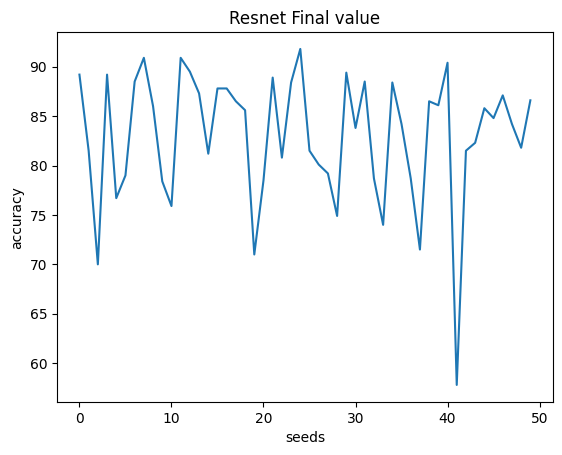

In [5]:
import matplotlib.pyplot as plt

plt.plot(accs_val)
plt.xlabel('seeds')
plt.ylabel('accuracy')
plt.title('Resnet Final value');
plt.savefig('C1val5seeds_bestmodel.png')